<a href="https://colab.research.google.com/github/mamoon0806/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
device = torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='data',
                            train=True,
                            transform=ToTensor(),
                            download=True)

test_data = datasets.MNIST(root='data',
                           train=False,
                           transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



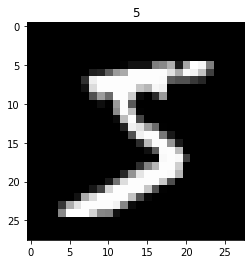

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title(f'{train_data.targets[0]}')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

loaders = {'train' : torch.utils.data.DataLoader(train_data,
                                                 batch_size=100,
                                                 shuffle=True,
                                                 num_workers=1),
           'test' : torch.utils.data.DataLoader(test_data,
                                                batch_size=100,
                                                shuffle=True,
                                                num_workers=1)}

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(16,32,5,1,2),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.out = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    #flatten to (batch, 32*7*7)
    x = x.view(x.size(0), -1)
    output = self.out(x)
    return output, x

cnn = CNN()
print(cnn)



CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
from torch.autograd import Variable

num_epochs = 10

def train(num_epochs, cnn, loaders):
  
  cnn.train()

  #Train
  total_step = len(loaders['train'])

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train']):

      #gives batch data, normalize x when iterate train_loader

      b_x = Variable(images)
      b_y = Variable(labels)

      output = cnn(b_x)[0]
      loss = loss_func(output, b_y)

      #clear gradients
      optimizer.zero_grad()

      #backprop
      loss.backward()

      #apply gradients
      optimizer.step()

      if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item()}')

train(num_epochs, cnn, loaders)





Epoch [1/10], Step [100/600], Loss: 0.23815687000751495
Epoch [1/10], Step [200/600], Loss: 0.15215596556663513
Epoch [1/10], Step [300/600], Loss: 0.15939806401729584
Epoch [1/10], Step [400/600], Loss: 0.17678695917129517
Epoch [1/10], Step [500/600], Loss: 0.036560188978910446
Epoch [1/10], Step [600/600], Loss: 0.04797397926449776
Epoch [2/10], Step [100/600], Loss: 0.14462894201278687
Epoch [2/10], Step [200/600], Loss: 0.16402624547481537
Epoch [2/10], Step [300/600], Loss: 0.12602798640727997
Epoch [2/10], Step [400/600], Loss: 0.077041395008564
Epoch [2/10], Step [500/600], Loss: 0.06724832206964493
Epoch [2/10], Step [600/600], Loss: 0.18492984771728516
Epoch [3/10], Step [100/600], Loss: 0.1017291247844696
Epoch [3/10], Step [200/600], Loss: 0.19286249577999115
Epoch [3/10], Step [300/600], Loss: 0.05388160049915314
Epoch [3/10], Step [400/600], Loss: 0.03230534866452217
Epoch [3/10], Step [500/600], Loss: 0.05876157432794571
Epoch [3/10], Step [600/600], Loss: 0.098175458610

In [ ]:
def test():
  cnn.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
      test_output, last_layer = cnn(images)
      pred_y = torch.max(test_output, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
      pass

  print(f'Test accuracy of the model on the 1000 test images: {accuracy}')

test()

Test accuracy of the model on the 1000 test images: 0.99


In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([5, 5, 5, 1, 1, 8, 7, 0, 6, 6])

In [ ]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 5 5 1 1 8 7 0 6 6]
Actual number: [5 5 5 1 1 8 7 0 6 6]
